# **Ensembles**

Este notebook está basado en el Capítulo del libro: A. Gerón, "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", 2nd Edition.

Primero importamos la librería numpy y librerías para los gráficos

In [1]:
import numpy as np

# Librerías para los gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Ensembles (idea intuitiva de su funcionamiento)

Ley de los grandes números

En el siguiente ejemplo vamos a simular el lanzamiento de 10 series de 100 lanzamientos de una moneda con una probabilidad de cara del 51%. 

In [2]:
heads_proba = 0.51
#Genera los lanzamientos entre 0 y 1, y comprueba si es < de 0.51, finalmente transforma true y false
coin_tosses = (np.random.rand(100, 10) < heads_proba).astype(np.int32) 
#Genera el acumulador de los lanzamientos dividido por el número de los lanzamientos
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 101).reshape(-1, 1) 

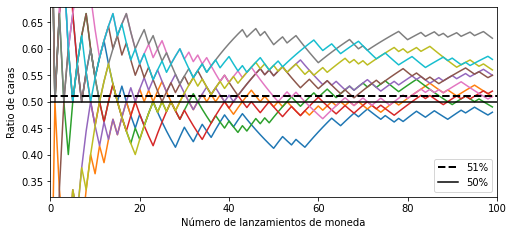

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 100], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 100], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Número de lanzamientos de moneda")
plt.ylabel("Ratio de caras")
plt.legend(loc="lower right")
plt.axis([0, 100, 0.32, 0.68])
#save_fig("Ley de los grandes números")
plt.show()

En este caso sale que 6 de la serie de lanzamientos es mayor del 50%. 

Si la moneda fuera un modelo con un 51% de acierto (un poco más que por azar), el aplicar 100 veces el modelo y hacer voto por mayoría nos daría un acierto alrededor del 60%.

Si en lugar de con 100 lanzamientos probamos series con 10000 lanzamientos.

In [4]:
heads_proba = 0.51
#Genera los lanzamientos entre 0 y 1, y comprueba si es < de 0.51, finalmente transforma true y false
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32) 
#Genera el acumulador de los lanzamientos dividido por el número de los lanzamientos
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

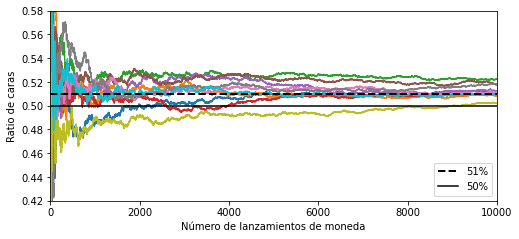

In [5]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Número de lanzamientos de moneda")
plt.ylabel("Ratio de caras")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
#save_fig("Ley de los grandes números")
plt.show()

En este caso, las 10 series dan por encima del 50% y por voto por mayoría tendríamos cierto (en un 97% de los casos, según las matemáticas).

# Ensembles basados en votos (mayoría o media)

Vamos a usar en esta práctica la base de datos moons. Es una base de datos usada habitualmente para evaluar modelos de clasificación. Tiene solo dos variables lo que permite realizar representaciones gráficas de la misma.

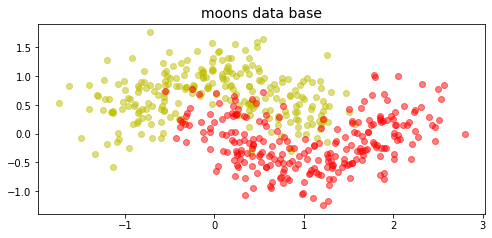

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3,  random_state=42)

#Pintamos la base de datos moons
plt.figure(figsize=(8,3.5))

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=0.5) #iterable
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'ro', alpha=0.5)
plt.title("moons data base", fontsize=14)
plt.show()

In [7]:
#Generamos el conjunto de test y de entrenamiento que usaremos en esta práctica
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

Comenzamos definiendo tres modelos diferentes: una regresión logística, un árbol de decisión y un SVM como clasificadores. 


Además, hacemos un ensemble de clasificación por mayoría en Scikit-Learn es VotingClassifier, con voting='hard'

In [8]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(random_state=42,  penalty='l2')
dt_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(C=0.5, random_state=42)


voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svm_clf)],
    voting='hard')

Entrenamos el modelo de ensemble. Observar los métodos que intervienen en el voting.

In [9]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('svc', SVC(C=0.5, random_state=42))])

Vamos a mirar la accuracy de cada clasificador por separdo y del ensemble:

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, dt_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))  

LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.88
VotingClassifier 0.888


Como puede observarse el clasificador basado en votos supera ligeramente a los clasificadores individuales. 

In [11]:
i=2
print("Clasificación del elemento", i+1)
for clf in (log_clf, dt_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "clasifica a:", y_pred[i])
print("El valor del elemento debería ser", y_test[i])

Clasificación del elemento 3
LogisticRegression clasifica a: 0
DecisionTreeClassifier clasifica a: 1
SVC clasifica a: 0
VotingClassifier clasifica a: 0
El valor del elemento debería ser 1


Si todos los clasificadores son capaces de estimar las probabilidades de clase (es decir, tienen una función asociada predict_proba()), entonces puedes decirle a Scikit-Learn que prediga la clase con la probabilidad de clase más alta promediando la los clasificadores individuales. 

Esto se llama votación "soft". 

A menudo logra un mayor rendimiento que la votación "hard" porque da más
peso a los votos de alta confianza. 

Todo lo que tienes que hacer es reemplazar el voting='hard' con
voting='soft' y asegurar que todos los clasificadores puedan estimar las probabilidades de clase. Esto es
no es el caso de la clase SVC por defecto, por lo que hay que establecer su hiperparámetro de probability a 
True (esto hará que la clase SVC utilice la validación cruzada para estimar las probabilidades de la clase y añadirá un método predict_proba(), ralentizando el entrenamiento). Vamos a modificar el código precedente para usar votación "soft".

In [12]:
log_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(C=0.5, probability=True, random_state=42)


voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svm_clf)],
    voting='soft')

¿Qué accuracy se obtiene?

In [13]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, dt_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))



LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.88
VotingClassifier 0.92


In [14]:
i=2
print("Clasificación del elemento", i+1)
for clf in (log_clf, dt_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "clasifica a:", y_pred[i])
print("El valor del elemento debería ser", y_test[i])

Clasificación del elemento 3
LogisticRegression clasifica a: 0
DecisionTreeClassifier clasifica a: 1
SVC clasifica a: 0
VotingClassifier clasifica a: 1
El valor del elemento debería ser 1


# Ensembles basados en votos ponderados (mayoría o media)

Podemos también hacer una votación hard o soft ponderada añadiendo pesos a cada modelo en el ensemble.

In [15]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svm_clf)], 
    weights = [0.3, 0.3, 0.4], # Pesos
    voting='soft')

for clf in (log_clf, dt_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.88
VotingClassifier 0.92


Hacemos una representación de la curva roc de los distintos estimadores.

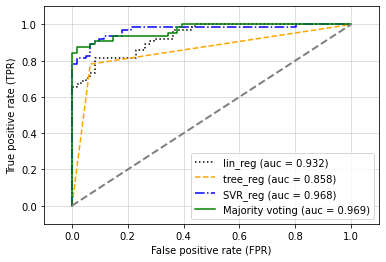

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-', '-']
clf_labels= ['lin_reg', 'tree_reg', 'SVR_reg','Majority voting']
all_clf = [log_clf, dt_clf, svm_clf, voting_clf]
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.3f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


plt.show()

En este estimador, también se observa que el voto por mayoría obtiene mejores resultados que los estimadores individuales.

## Ejercicios Ensembles basados en votos

Recuperamos la base de datos de la práctica anterior sobre la diabetes. Recordar que esta base de datos era un problema de regresión en el que intentábamos estimar la progresión de la enfermedad a un año.

De este modo el ensemble se obtendrá a partir de la media de los resultados y no por mayoría.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#Importamos la BD diabetes con la misma configuración de la práctica anterior.

from sklearn import datasets

diabetes_BD = datasets.load_diabetes()
print(diabetes_BD.DESCR)

diabetes=diabetes_BD["data"] # Datos a usar 
feature_names=diabetes_BD["feature_names"] # Nombre de las variable
diabetes_target=diabetes_BD["target"] # Dato a inferir. 

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Para poder comparar consideramos el mismo conjunto de train y test. Recordamos que los datos ya estan estandarizados.

In [18]:
from sklearn.model_selection import train_test_split
X_train_diabetes,  X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(diabetes, diabetes_target, test_size=0.2, random_state=42)

EJERCICIO. Definir un modelo de regresión lineal, un árbol de decisión para regresiones y una máquina de vectores soporte para regresiones. Dejar los modelos con los hiperparámetros por defecto, excepto para el árbol de decisión que indicamos random_state=42.

Integrar los tres modelos anteriores en un ensemble. Entrenar los tres modelos en el conjunto de entrenamiento por separado y el ensemble basado en media. Scikit learn tiene la clase VotingRegressor para ensembles basados en media. 

Mostrar los resultados sobre el conunto de test a través del RMSE:

np.sqrt(mean_squared_error(y_test, y_pred))

¿Consigue el ensemble mejorar los resultados individuales?

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

# Solución


lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
SVR_reg = SVR()

voting_reg = VotingRegressor(
    estimators=[('lr', lin_reg), ('dt', tree_reg), ('svr', SVR_reg)])
for reg in (lin_reg, tree_reg, SVR_reg, voting_reg):
  reg.fit(X_train_diabetes, y_train_diabetes)
  y_pred_diabetes = reg.predict(X_test_diabetes)
  print(reg,np.sqrt(mean_squared_error(y_test_diabetes, y_pred_diabetes)))

LinearRegression() 53.8532569849144
DecisionTreeRegressor(random_state=42) 70.61829663921893
SVR() 65.82766241937706
VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('dt', DecisionTreeRegressor(random_state=42)),
                            ('svr', SVR())]) 54.846901253273316


EJERCICIO: Repite en ensemble anterior pero añadiendo los siguientes pesos a los tres modelos:

- Regresión lineal: 40%
- Árbol de decisión: 30%
- SVR: 30%

¿Mejoras los resultados?

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
# Solución

lin_reg = LinearRegression(40)
tree_reg = DecisionTreeRegressor(random_state=30)
SVR_reg = SVR(30)

voting_reg = VotingRegressor(
    estimators=[('lr', lin_reg), ('dt', tree_reg), ('svr', SVR_reg)])
for reg in (lin_reg, tree_reg, SVR_reg, voting_reg):
  reg.fit(X_train_diabetes, y_train_diabetes)
  y_pred_diabetes = reg.predict(X_test_diabetes)
  print(reg,np.sqrt(mean_squared_error(y_test_diabetes, y_pred_diabetes)))

EJERCICIO (Opcional). Añade al ensemble la siguiente red neuronal. No es necesario que le pongas ningún peso a los modelos en el ensemble. ¿Es el resultado de la red neuronal mejor que el del ensemble anterior?¿Al añadirla al ensemble se mejora los resultados del mismo?¿Por qué? 

In [21]:
from sklearn.neural_network import MLPRegressor

NN_reg = MLPRegressor(solver='sgd', alpha=0.001, momentum=0.9, activation='relu',
                    hidden_layer_sizes= (5, 2), random_state=42,  max_iter=2000)

# Solución


PREGUNTA (Opcional) Vamos a probar cómo funciona el voto por mayoría en otro problema de clasificación. Para ello, usaremos una BD para detección del [cáncer de mama](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). Importamos la librería y le echamos un vistazo. ¿Estandarizarías o normalizarías los datos?

In [22]:
from sklearn.datasets import load_breast_cancer, load_diabetes, fetch_20newsgroups,fetch_20newsgroups_vectorized
breast_cancer_BD = load_breast_cancer()

import pandas as pd
data_breast_cancer=pd.DataFrame(data=breast_cancer_BD.data,columns=breast_cancer_BD.feature_names)
target_breast_cancer=pd.DataFrame(data=breast_cancer_BD.target,columns=['target'])
df=pd.concat([data_breast_cancer,target_breast_cancer],sort=True,axis=1)
df.head(15)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.049040,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.013080,0.01860,0.013400,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.040060,0.03832,0.020580,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.074580,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.024610,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.033450,0.03672,0.011370,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.013820,0.02254,0.010390,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.030290,0.02488,0.014480,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.035020,0.03553,0.012260,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.072170,0.07743,0.014320,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0


Respuesta:

Partimos la BD en conjuntos de train y test (20%) y estandarizamos los datos.

In [23]:
breast_cancer=breast_cancer_BD["data"] # Datos a usar 
feature_names=breast_cancer_BD["feature_names"] # Nombre de las variables
breast_cancer_target=breast_cancer_BD["target"] # Dato a inferir.

from sklearn.model_selection import train_test_split
X_train_breast,  X_test_breast, y_train_breast, y_test_breast = train_test_split(breast_cancer, breast_cancer_target, test_size=0.2, random_state=42)

from sklearn import preprocessing
convert = preprocessing.StandardScaler() 

X_train_breast = convert.fit_transform(X_train_breast) 
X_test_breast = convert.transform(X_test_breast)

EJERCICIO (Opcional). Realiza un ensemble por voto por mayoría para los tres clasificadores siguientes. ¿Funciona mejor una votación por mayoría hard o soft?

In [24]:
log_clf = LogisticRegression(random_state=42, solver= 'liblinear') # Solver 'liblinear' funciona mejor para BD pequeñas, según documentación
dt_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

# Solución 


# Bagging ensembles

La técnica de bagging consiste en entrenar un mismo modelo pero sobre subconjuntos aleatorios de datos del conjunto de entrenamiento.

El siguiente código entrena un ensemble de 500 árboles de decisión, entrenados sobre 100 instancias aleatoriamente elegidas del conjunto de entrenamiento con reemplazamiento.

La función BaggingClassifier automáticamente realiza soft voting en lugar de hard voting si el clasificador base puede estimar la probabilidad de la clase
(es decir, si dispone del método predict_proba()), que es el caso de los árboles de decisión.

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

Entrenamos el modelo creado sobre el mismo conjunto de datos de moons anterior y miramos la accuracy que obtenemos sobre el conjunto de test.

In [26]:
bag_clf.fit(X_train, y_train)
y_train_tree = bag_clf.predict(X_train)
print("Accuracy sobre el conjunto de entrenamiento",accuracy_score(y_train, y_train_tree))

y_pred = bag_clf.predict(X_test)
print("Accuracy sobre el conjunto de test", accuracy_score(y_test, y_pred))

Accuracy sobre el conjunto de entrenamiento 0.9386666666666666
Accuracy sobre el conjunto de test 0.904


La opción de hacer muestras con reemplazamiento es la que se activa por defecto. Si es su lugar prefieres sin reemplazamiento, es decir **pasting** en lugar de bagging se debe elegir bootstrap=False.

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1, random_state=42)

In [28]:
bag_clf.fit(X_train, y_train)
y_train_tree = bag_clf.predict(X_train)
print("Accuracy sobre el conjunto de entrenamiento",accuracy_score(y_train, y_train_tree))

y_pred_bag = bag_clf.predict(X_test)
print("Accuracy sobre el conjunto de test", accuracy_score(y_test, y_pred_bag))

Accuracy sobre el conjunto de entrenamiento 0.9386666666666666
Accuracy sobre el conjunto de test 0.92


Si lo comparamos con lo que obtenemos solo con un árbol de decisión entrenado sobre todo el conjunto de entrenamiento, se observa que mejora bastante. En particular se observa que un solo árbol actúa mejor sobre el conjunto de entrenamiento, pero peor sobre el conjunto de test.

In [29]:
tree_clf = DecisionTreeClassifier(random_state=42,max_depth=8)
tree_clf.fit(X_train, y_train)
y_train_tree = tree_clf.predict(X_train)
print("Accuracy sobre el conjunto de entrenamiento",accuracy_score(y_train, y_train_tree))

y_pred_tree = tree_clf.predict(X_test)
print("Accuracy sobre el conjunto de test", accuracy_score(y_test, y_pred_tree))


Accuracy sobre el conjunto de entrenamiento 0.9786666666666667
Accuracy sobre el conjunto de test 0.88


Comparamos a continuación la frontera de desición de un solo árbol de decisión con la de los realizados con el método boosting.

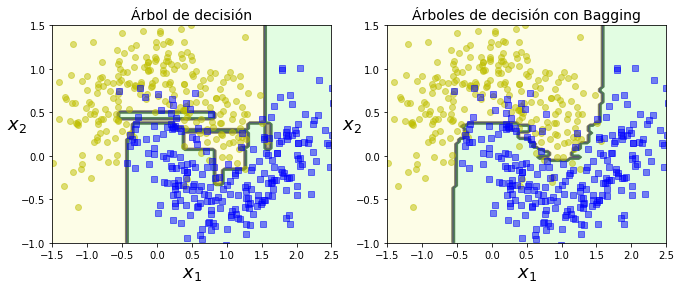

In [30]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y) # Un solo árbol de decisión
plt.title("Árbol de decisión", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y) # Bagging de árboles de decisión
plt.title("Árboles de decisión con Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

La clase BaggingClassifier también soporta el muestreo de las características, en lugar del muestreo de instancias. Este es controlado por dos hiperparámetros: max_features y bootstrap_features (es decir, bootstrap_features=True y/o max_features un número o un porcentaje del total). Funcionan de la misma manera que max_samples y bootstrap. Así, cada predictor se entrenará en un subconjunto aleatorio de las características de entrada. Esto es particularmente útil cuando se trata de entradas de alta dimensión (como las imágenes). Este método se llama se llama el método **Random Subspaces**.

El muestreo tanto de las instancias como de las características se denomina método **Random
Patches**.  

Probamos a hacer un random patches, aunque en este caso solo tenemos dos features.

In [31]:
X_train.shape

(375, 2)

In [32]:
bag_clf_RandomPatches = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=1000,
    max_samples=100, bootstrap=True, max_features=1, bootstrap_features=True, n_jobs=-1, random_state=42)

In [33]:
bag_clf_RandomPatches.fit(X_train, y_train)
y_train_tree = bag_clf_RandomPatches.predict(X_train)
print("Accuracy sobre el conjunto de entrenamiento",accuracy_score(y_train, y_train_tree))

y_pred_patch = bag_clf_RandomPatches.predict(X_test)
print("Accuracy sobre el conjunto de test", accuracy_score(y_test, y_pred_patch))

Accuracy sobre el conjunto de entrenamiento 0.9546666666666667
Accuracy sobre el conjunto de test 0.856


##Ejercicios Bagging

EJERCICIO. Sobre la BD de diabetes prueba a hacer un Bagging con la RNN que se propone. Utiliza 200 estimadores y que cada uno pueda usar como máximo 100 elementos. Fíjate que necesitas el método BaggingRegressor en lugar de BaggingClassifier. ¿Qué RMSE obtienes sobre el conjunto de entrenamiento?¿Y sobre el conjunto de test?¿Cuánto tiempo le lleva?

In [34]:
%%time

from sklearn.ensemble import BaggingRegressor

NN_reg = MLPRegressor(solver='sgd', alpha=0.001, momentum=0.9, activation='relu',
                    hidden_layer_sizes= (5, 2), random_state=42,  max_iter=2000)

# Solución

bag_rg = BaggingRegressor(
    NN_reg, n_estimators=200,
    max_samples=200, bootstrap=True, n_jobs=-1, random_state=42)

bag_reg.fit(X_train_diabetes, y_train_diabetes)
y_train_NN_reg_diabetes=bag_rg


CPU times: user 31 µs, sys: 3 µs, total: 34 µs
Wall time: 36.5 µs


EJERCICIO: Probablemente habrás observado que entrenar cada RNN lleva un tiempo. Parece razonable utilizar métodos algo más rápidos de entrenar como los árboles de decisión.

Repite el ensemble anterior con 500 árboles de decisión. ¿Qué RMSE obtienes sobre el conjunto de entrenamiento?¿Y sobre el conjunto de test?¿Cuánto tiempo le lleva?¿Es más rápido?

In [35]:
%%time

from sklearn.ensemble import BaggingRegressor

dt_reg = DecisionTreeRegressor(random_state=42)

# Solución


CPU times: user 0 ns, sys: 42 µs, total: 42 µs
Wall time: 47.2 µs


EJERCICIO (Opcional). Repite el ensemble anterior con random patches (eligiendo cada estimador 5 características). ¿Se mejora el resultado?

In [36]:
%%time
# Solución
from sklearn.ensemble import BaggingRegressor
dt_reg = DecisionTreeClassifierRegressor(random_state=42)


bag_rg_DT = BaggingRegressor(
    dt_reg, n_estimators=500,
    max_samples=100, max_features=5, bootstrap=False, n_jobs=-1, random_state=42)

bag_reg.fit(X_train_diabetes, y_train_diabetes)
y_train_NN_reg_diabetes=bag_rg


CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 31 µs


# Random Forests


Random Forest es un conjunto de árboles de decisión, generalmente entrenado a través del método de boosting (o a veces pasting). El algoritmo del Random Forest introduce una aleatoriedad extra en el crecimiento de los árboles;
en lugar de buscar la mejor característica al dividir un nodo, se
busca la mejor característica entre un subconjunto aleatorio de características. Esto da como resultado un
mayor diversidad de árboles, que generalmente dan un mejor modelo en general.

In [37]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random",  random_state=42),
    n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42) 
# splitter: The strategy used to choose the split at each node (best or random).

In [38]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


El método RandomForestClassifier tiene los hiperparámetros del método DecisionTreeClassifier (para controlar cómo crecen los árboles), más los hiperparámetros del método BaggingClassifier para controlar la forma de hacer ensemble (con algunas excepciones).

La clase RandomForestClassifier está optimizada y es conveniente usarla en lugar de la combinación de DecisionTreeClassifier mas BaggingClassifier (de igual modo, existe una clase RandomForestRegressor para tareas de regresión). 

El siguiente código entrena un clasificador Random Forest con 500 árboles en los que se hace bagging con un máximo de 100 de elementos. Es equivalente al anterior BaggingClassifier.

In [39]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_samples = 100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.92


Mejora un poco, aunque las predicciones son casi idénticas al bagging anterior.

In [40]:
np.sum(y_pred_bag == y_pred_rf) / len(y_pred)  

0.984

## Hiperparámetros del Random Forest

### Explorar el número de elementos para entrenar (Number of Samples)

Cada árbol de decisión del ensemble se entrena en una muestra de extraída del conjunto de datos de entrenamiento.

Esto se puede desactivar estableciendo el argumento "bootstrap" a False, si lo desea. En ese caso, todo el conjunto de datos de entrenamiento se utilizará para entrenar cada árbol de decisión. Esto no es recomendable.

El argumento **max_samples** se puede configurar como un número entero (que marca el tamaño máximo) o como un número decimal entre 0 y 1 para controlar el porcentaje del tamaño del conjunto de datos de entrenamiento para hacer que la muestra se utilice para entrenar cada árbol de decisión.

Por ejemplo, si el conjunto de datos de entrenamiento tiene 100 filas, el argumento max_samples puede establecerse en 0,5 y cada árbol de decisión se entrenará sobre una muestra de con (100 * 0,5) o 50 filas de datos.

Un tamaño de muestra más pequeño hará que los árboles sean más diferentes, y un tamaño de muestra más grande hará que los árboles sean más similares. Si se establece max_samples en "None", el tamaño de la muestra será el mismo que el del conjunto de datos de entrenamiento, y éste es el valor predeterminado.

El ejemplo que figura a continuación demuestra el efecto de diferentes tamaños de muestra del 10 al 100% en el algoritmo.

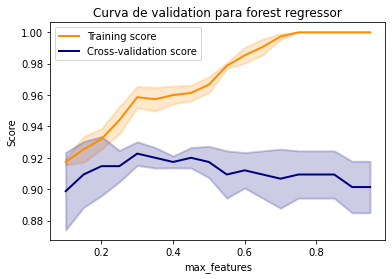

CPU times: user 43.1 s, sys: 3.14 s, total: 46.3 s
Wall time: 1min 12s


In [41]:
%%time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

#Lista de parámetros
param_range =  [x/100 for x in range(10,100,5)]

rnd_clf = RandomForestClassifier(n_estimators=500,  n_jobs=-1, random_state=42)
#Curva de validación
train_scores, validation_scores = validation_curve(    
    rnd_clf, X_train, y_train, param_name="max_samples", param_range=param_range,
    scoring='accuracy', cv=3, n_jobs=1)

#Pintamos la curva
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.title("Curva de validation para forest regressor")
plt.xlabel(r"max_features")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, validation_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

En este caso parece que aumenta hasta 30% y después tiende a disminuir.

In [42]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_samples = 0.30, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.912


Para hacer el gráfico anterior hemos realizado cross validation. En el caso de Random Forest podemos utilizar los elementos out of bag.

## Evaluación Out-of-Bag

Con bagging, algunas instancias del conjunto de entrenamiento pueden ser elegidas varias veces, mientras que otras pueden no ser elegidas nunca. Por defecto, BaggingClassifier elige m instancias de entrenamiento con reemplazo (bootstrap=True), donde m es el tamaño del conjunto de entrenamiento elegido. Así, suponer que usa el 30% de las instancias de entrenamiento para un modelo. El 70% restante de los casos de entrenamiento se denominan instancias fuera de la bolsa (out-of-bag oob). Obsérvese que no son las mismas 70% para todos los predictores.
Dado que un predictor nunca ve las instancias de oob durante el entrenamiento, estas podrían elegirse como instancias de validación, sin necesidad de un conjunto de validación separado. 

En Scikit-Learn, puedes establecer **oob_score**=True al crear un BaggingClassifier para
solicitar una evaluación automática del oob después del entrenamiento. La puntuación de evaluación resultante está disponible a través de la variable oob_score_.

In [43]:
%%time

from sklearn.model_selection import GridSearchCV


RF_oob = RandomForestClassifier(n_estimators=500, max_samples = 0.30, oob_score=True, bootstrap=True,  n_jobs=-1, random_state=42)
RF_oob.fit(X_train, y_train)
print(RF_oob.oob_score_)

0.9253333333333333
CPU times: user 1.27 s, sys: 131 ms, total: 1.4 s
Wall time: 1.31 s


De acuerdo con esta evaluación sobre los elementos oob, este Random Forest obtiene sobre un 92.5% de accuracy sobre el conjunto de oob.

Sobre el conjunto de test reservado

In [44]:
from sklearn.metrics import accuracy_score
y_pred = RF_oob.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Si hacemos valiración cruzada, obtenemos un accuracy similar pero en algo más de tiempo. Además se tiene que considerar que en cada fold se tiene dos tercios de la muestra.

In [45]:
%%time

from sklearn.model_selection import cross_val_score

RF_oob_F = RandomForestClassifier(n_estimators=500, max_samples = 0.30, oob_score=False, bootstrap=True,  n_jobs=-1, random_state=42)


n_scores = cross_val_score(RF_oob_F, X_train, y_train, scoring='accuracy', cv=3, n_jobs=-1, error_score='raise')

print((n_scores).mean())

0.9226666666666667
CPU times: user 34.5 ms, sys: 1.12 ms, total: 35.6 ms
Wall time: 2.78 s


De esta forma, para el ejemplo del Random Forest anterior podemos ahorrarnos la validación cruzada y utlizar en su lugar los elementos oob.

#### Explorar el número de árboles

El número de árboles a incluir es un hiperámetro importante. Podemos ir añadiendo árboles hasta que notemos que no se produce una mejoría.

En este caso, utilizaremos oob en lugar de validación cruzada.

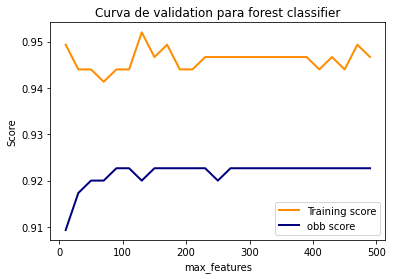

CPU times: user 17.9 s, sys: 2.33 s, total: 20.2 s
Wall time: 20.5 s


In [46]:
%%time

acc_train=[]
acc_validation=[]
param_range = range(10,500,20)
for n in param_range:
    rnd_clf = RandomForestClassifier(n_estimators=n, max_samples = 0.3, oob_score=True, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train, y_train)
    y_pred_rf = rnd_clf.predict(X_train)
    acc_train.append(accuracy_score(y_train, y_pred_rf))
    acc_validation.append(rnd_clf.oob_score_)
      

plt.title("Curva de validation para forest classifier")
plt.xlabel(r"max_features")
plt.ylabel("Score")
lw = 2
plt.plot(param_range,acc_train, label="Training score",
             color="darkorange", lw=lw)
plt.plot(param_range, acc_validation, label="obb score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

En este caso, parece que a partir de 100 árboles no se produce mejoría.

#### Explorar el número de características

El número de características que se muestrean al azar para cada punto de división es una de las características más importantes a configurar para el randon forest.

Se establece mediante el argumento max_features y por defecto a la raíz cuadrada del número de características de entrada. 

En nuestro ejemplo solo tenemos dos características por lo que no podemos jugar demasiado con este argumento.

Vamos a cambiar un momento de ejemplo generando un conjunto de datos sintético.


In [47]:
# Ejemplo sintético de una muestra con 1000 ejemplos y 20 características.
from sklearn.datasets import make_classification

X1, y1 = make_classification(n_samples=1000, n_features=20, random_state=42)
#Generamos el conjunto de test y de entrenamiento que usaremos en esta práctica
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,random_state=42)


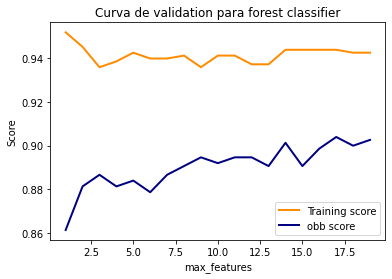

CPU times: user 8.41 s, sys: 748 ms, total: 9.16 s
Wall time: 9.11 s


In [48]:
%%time
   
acc_train=[]
acc_validation=[]
param_range = range(1,20)
for f in param_range:
    rnd_clf = RandomForestClassifier(n_estimators=100,  max_samples = 0.3, max_features = f, oob_score=True, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train1, y_train1)
    y_pred_rf = rnd_clf.predict(X_train1)
    acc_train.append(accuracy_score(y_train1, y_pred_rf))
    acc_validation.append(rnd_clf.oob_score_)
      

plt.title("Curva de validation para forest classifier")
plt.xlabel(r"max_features")
plt.ylabel("Score")
lw = 2
plt.plot(param_range,acc_train, label="Training score",
             color="darkorange", lw=lw)
plt.plot(param_range, acc_validation, label="obb score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


En este caso, alrededor de 17 características es lo que parece que produce mejores resultados.

#### Explorar la profundad del árbol

Existen otros hiperparámetros a explorar, que van más allá del bagging. 

Exploramos por ejemplo, la profundidad máxima de los árboles de decisión utilizados en el conjunto.

Por defecto, los árboles se construyen a una profundidad arbitraria y no se podan. Este es un defecto sensato, aunque también podemos explorar árboles de ajuste con diferentes profundidades fijas.

La profundidad máxima del árbol puede especificarse mediante el argumento max_depth y se establece en Ninguno (sin profundidad máxima) por defecto.

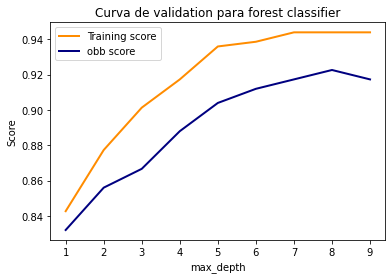

CPU times: user 2.87 s, sys: 372 ms, total: 3.24 s
Wall time: 3.7 s


In [49]:
%%time

acc_train=[]
acc_validation=[]
param_range = range(1,10)
for d in param_range:
    rnd_clf = RandomForestClassifier(n_estimators=100,  max_samples = 0.3,  max_depth=d, oob_score=True, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train, y_train)
    y_pred_rf = rnd_clf.predict(X_train)
    acc_train.append(accuracy_score(y_train, y_pred_rf))
    acc_validation.append(rnd_clf.oob_score_)
      

plt.title("Curva de validation para forest classifier")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
lw = 2
plt.plot(param_range,acc_train, label="Training score",
             color="darkorange", lw=lw)
plt.plot(param_range, acc_validation, label="obb score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

En este caso la profundidad mejora el rendimiento, hasta que  parece que el rendimiento va creciendo con la profundidad. 

Probemos sobre los datos del test.

In [50]:
rnd_clf = RandomForestClassifier(n_estimators=100, max_samples = 0.3, max_depth=10, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.92


## Ejercicios Random Forest

EJERCICIO: Sobre la BD Diabetes entrena un random forest regressor. Utiliza como hiperparámetros del random forest max_samples=100, n_estimators=300, n_jobs=-1, random_state=42.
¿Qué RMSE obtienes sobre el conjunto de entrenamiento?
¿Y sobre el conjunto de test?




In [51]:
from sklearn.ensemble import RandomForestRegressor

# Solución
forest_reg = RandomForestRegressor(max_samples=100, n_estimators=300, n_jobs=-1 random_state=42)
forest_reg.fit(X_train_diabetes, y_train_diabetes)
y_train_RF_diabetes=forest_reg.predict(X_train_diabetes)
print("RMSE sobre el conjunto de entrenamiento RandomForestRegressor", np.sqrt(mean_squared_error))

EJERCICIO: Realiza una curva de validación sobre el argumento max_depth. Prueba para el RandomForestRegressor siguiente en el rango de parámetros suministrado. Interpreta el resultado.

In [52]:
%%time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

#Lista de parámetros

param_range = range(1,10)

rnd_clf = RandomForestRegressor(max_samples=100, n_estimators=300, n_jobs=-1, random_state=42)

#Curva de validación
#Solución



CPU times: user 60 µs, sys: 5 µs, total: 65 µs
Wall time: 70.6 µs


In [53]:
#Gráfica usando oob_scores
# Solución


EJERCICO (Opcional): Realiza una búsqueda aleatoria para un random forest regressor sobre los hiperparámetros estudiados según la cuadrícula proporcionada. Usa validación cruzada con tres folds.
¿Cuál es la mejor combinación de parámetros?¿Usa bagging (coge un subconjunto de la muestra para entrenar), random pathches o random subspaces?
¿Qué RMSE obtienes sobre el conjunto de que usa para realizar validación cruzada?¿y sobre el conjunto de test?

In [54]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid = {
        #'bootstrap'=[False, True],
        'n_estimators': [30, 100, 300],
        'max_features': [3, 5, 8, None],
        'max_depth': [3, 7, 10, None],
        'max_samples': [30, 100, 200, None]
    }

forest_reg = RandomForestRegressor(random_state=42, bootstrap=False) 

# Solución


CPU times: user 82 µs, sys: 8 µs, total: 90 µs
Wall time: 97.3 µs


Explicar si usa bagging, random pathches o random subspaces


# Métodos Boosting

# AdaBoost

Los métodos de boosting entrenan modelos de forma secuencial en los que un modelo trata de corregir los errores del modelo anterior.

Trabajaremos sobre la misma BD moons.

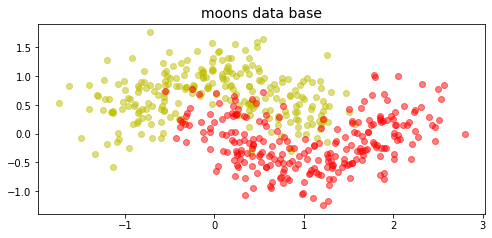

In [55]:
#Primero generamos el conjunto de datos moons
import numpy as np

# Librerías para los gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3,  random_state=42)

#Pintamos la base de datos moons
plt.figure(figsize=(8,3.5))

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=0.5) #iterable
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'ro', alpha=0.5)
plt.title("moons data base", fontsize=14)
plt.show()
#Generamos el conjunto de test y de entrenamiento que usaremos en esta práctica
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

El siguiente código entrena un clasificador AdaBoost basado en 200 árboles de decisión usando la clase AdaBoostClassifier de Scikit-Learn (como es de esperar, también hay una clase AdaBoostRegressor). 

Los árboles de decisión que se usan en el ejemplo tienen max_depth=1, en otras palabras, un árbol compuesto por un único nodo de decisión más dos nodos de hoja. Son métodos de clásificación bastante débiles, pero que mejoran progresivamente con el método de boosting.


In [56]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
    learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

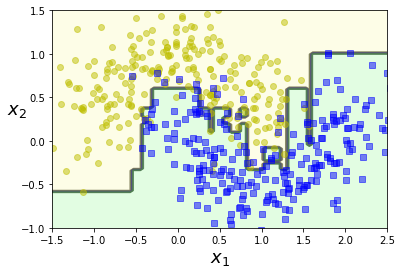

In [57]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


plot_decision_boundary(ada_clf, X, y)

En el siguiente ejemplo, se implementa el método de Boosting para ver su funcionamiento. 

En concreto en la siguiente figura se muestra la frontera de decisión de cinco predictores consecutivos (cada predictor es un clasificador SVM con un kernel RBF). El primer clasificador se equivoca en muchas instancias, y los pesos de estas instancias se incrementan. El segundo clasificador, por lo tanto, hace un mejor trabajo en estas instancias. No obstante, con una tasa de aprendizaje de 1 hace que el clasificador trate de ajustar a determinados elementos demasiado rápido y el clasificador empeore. El gráfico de la derecha representa la misma secuencia de predictores, excepto que la tasa de aprendizaje se reduce a 0.2 (es decir, los pesos de las instancias mal clasificadas se incrementan en un quinto en cada iteración). Como puede ver, esta técnica de aprendizaje secuencial tiene algunas similitudes con el Descenso del Gradiente, excepto que en lugar de ajustar los parámetros de un solo predictor para minimizar una función de coste, AdaBoost añade predictores al conjunto, haciéndolo gradualmente mejor.

Iteración: 0 ratio aprendizaje: 1 accuracy 0.872
Iteración: 1 ratio aprendizaje: 1 accuracy 0.856
Iteración: 2 ratio aprendizaje: 1 accuracy 0.88
Iteración: 3 ratio aprendizaje: 1 accuracy 0.856
Iteración: 4 ratio aprendizaje: 1 accuracy 0.552
Iteración: 5 ratio aprendizaje: 1 accuracy 0.528
Iteración: 6 ratio aprendizaje: 1 accuracy 0.656
Iteración: 7 ratio aprendizaje: 1 accuracy 0.68
Iteración: 8 ratio aprendizaje: 1 accuracy 0.688
Iteración: 9 ratio aprendizaje: 1 accuracy 0.504
Iteración: 0 ratio aprendizaje: 0.2 accuracy 0.872
Iteración: 1 ratio aprendizaje: 0.2 accuracy 0.872
Iteración: 2 ratio aprendizaje: 0.2 accuracy 0.872
Iteración: 3 ratio aprendizaje: 0.2 accuracy 0.864
Iteración: 4 ratio aprendizaje: 0.2 accuracy 0.856
Iteración: 5 ratio aprendizaje: 0.2 accuracy 0.864
Iteración: 6 ratio aprendizaje: 0.2 accuracy 0.872
Iteración: 7 ratio aprendizaje: 0.2 accuracy 0.856
Iteración: 8 ratio aprendizaje: 0.2 accuracy 0.864
Iteración: 9 ratio aprendizaje: 0.2 accuracy 0.888


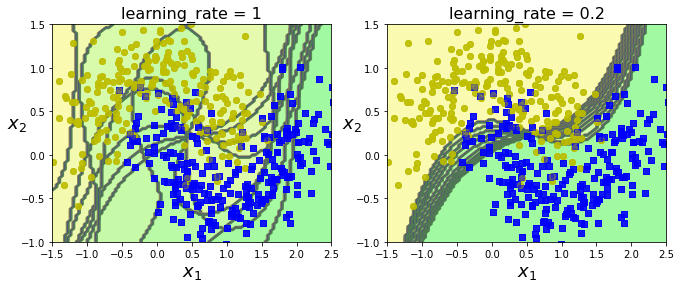

In [58]:
from sklearn.svm import SVC

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.2)):
    sample_weights = np.ones(len(X_train)) # Pesos
    plt.subplot(subplot)
    for i in range(10):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights) # Se incrementan los pesos en los valores
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate) #Se añade más peso a los que no acierta
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
        
        y_pred = svm_clf.predict(X_test)
        print("Iteración:", i, "ratio aprendizaje:", learning_rate,  "accuracy", accuracy_score(y_test, y_pred))
#save_fig("boosting_plot")
plt.show()



Utilizamos ahora 200 estimadores SVC con un ratio de apredizaje de 0.2

In [59]:
ada_clf_SVC = AdaBoostClassifier(
    SVC(kernel="rbf", C=0.05, gamma="auto", probability=True, random_state=42), n_estimators=200,
    learning_rate=0.2, random_state=42) #Añadimos más estimadores y ponermos el ratio de aprendizaje más pequeño
ada_clf_SVC.fit(X_train, y_train)

y_pred = ada_clf_SVC.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

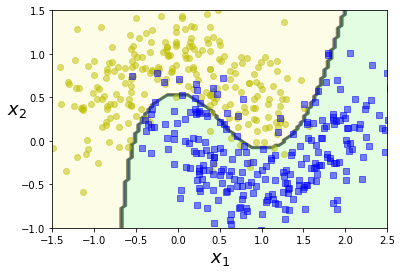

In [60]:
plot_decision_boundary(ada_clf_SVC, X, y)

## Ejercicios AdaBoosting

Cargamos de nuevo la BD Diabetes para hacer ejercicios sobre ella.

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#Importamos la BD Diabetes con la misma configuración de la práctica anterior.

from sklearn import datasets
diabetes_BD = datasets.load_diabetes()

diabetes=diabetes_BD["data"] # Datos de las casas a usar 
feature_names=diabetes_BD["feature_names"] # Nombre de las variable
diabetes_target=diabetes_BD["target"] # Dato a inferir. Precio medio de las casas

# Repartimos en conjunto de entrenamiento y test

from sklearn.model_selection import train_test_split
X_train_diabetes,  X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(diabetes, diabetes_target, test_size=0.2, random_state=42)



EJERCICIO: Sobre la BD Diabetes aplica el método AdaBoosting.
Utiliza 200 árboles de decisión (cada uno que utilice como máximo 5 características). Prueba 4 ratios de aprendizje distintos: 0.1, 0.25, 0.5 y 1. ¿Qué RMSE obtienes sobre el conjunto de entrenamiento en los cuatro métodos? ¿Y sobre el conjunto de test?¿Qué ratio da mejores resultados?

In [62]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Solución


Pregunta: ¿Mejora si se añaden más estimadores (árboles de decisión, en este caso)? Prueba a poner 500 y 1000, con el ratio de aprendizaje 0.25.

In [63]:
#Solución


EJERCICIO (Opcional). Prueba ahora a cambiar el modelo base. Por ejemplo, pon un SVR o una regresión lineal. ¿Consigues mejorar el resultado? Puedes probar con 200 estimadores y los ratio de aprendizaje 0.1.

In [64]:
from sklearn.svm import SVR
svm_reg = SVR(kernel="rbf", C=5, gamma="auto")

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

# Solución


# Gradient Boosting

El siguiente ejemplo trata de ilustrar cómo funciona Gradient Tree Boosting, o Gradient Boosted Regression Trees (GBRT). 

En este caso, vamos a generar un conjunto de entrenamiento aleatorio cuadrático.

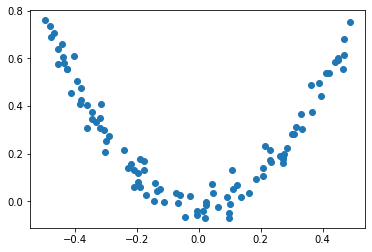

In [88]:
np.random.seed(42)
Xrand = np.random.rand(100, 1) - 0.5
yrand = 3*Xrand[:, 0]**2 + 0.05 * np.random.randn(100)

plt.plot(Xrand,yrand, 'o')

Primero aplicamos un DecisionTreeRegressor al conjunto de entrenamiento.

In [89]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(Xrand, yrand)

DecisionTreeRegressor(max_depth=2, random_state=42)

Ahora entrenamos un segundo DecisionTreeRegressor sobre los errores residuales cometidos por el primer modelo:

In [90]:
y2 = yrand - tree_reg1.predict(Xrand)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(Xrand, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Entrenamos ahora un tercer modelo sobre los errores cometidos por el segundo modelo:

In [91]:
y3 = y2 - tree_reg2.predict(Xrand)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(Xrand, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Finalmente, hacemos un ensemble conteniendo los tres árboles. Podemos hacer predicciones sobre una nueva instancia simplemente añadiendo las predicciones de las tres anteriores:

In [92]:
print("Primer elemento del conjunto de entrenamiento:", Xrand[0], "Solución a aproximar:", yrand[0])
print("Resultado primera iteración:", tree_reg1.predict([Xrand[0]]))
print("Resultado segunda iteración:", tree_reg1.predict([Xrand[0]])+tree_reg2.predict([Xrand[0]]))
print("Resultado tercera iteración:",tree_reg1.predict([Xrand[0]])+tree_reg2.predict([Xrand[0]])+tree_reg3.predict([Xrand[0]])) 

# Definimos una nueva instancia

X_new = np.array([[0.25]]) 
print("Valor para la nueva instancia", X_new,"a aproximar:", 3*X_new**2 + 0.05 * np.random.randn(1))
print("Resultado primera iteración:", tree_reg1.predict(X_new))
print("Resultado segunda iteración:", tree_reg1.predict(X_new)+tree_reg2.predict(X_new))
print("Resultado tercera iteración:",tree_reg1.predict(X_new)+tree_reg2.predict(X_new)+tree_reg3.predict(X_new))  


Primer elemento del conjunto de entrenamiento: [-0.12545988] Solución a aproximar: 0.05157289874841034
Resultado primera iteración: [0.12356613]
Resultado segunda iteración: [0.03316819]
Resultado tercera iteración: [0.04021166]
Valor para la nueva instancia [[0.25]] a aproximar: [[0.18815009]]
Resultado primera iteración: [0.12356613]
Resultado segunda iteración: [0.1634791]
Resultado tercera iteración: [0.17052257]


La siguiente figura representa las predicciones de estos tres árboles en la columna de la izquierda, y el
las predicciones del ensemble en la columna derecha. En la primera fila, el conjunto tiene sólo una
por lo que sus predicciones son exactamente las mismas que las del primer árbol. En el segundo
se entrena un nuevo árbol sobre los errores residuales del primer árbol. A la derecha puedes
ver que las predicciones del conjunto son iguales a la suma de las predicciones de los dos primeros árboles. De manera similar, en la tercera fila otro árbol está entrenado en los errores residuales de
el segundo árbol. Se puede ver que las predicciones del conjunto mejoran gradualmente a medida que
los árboles se añaden al conjunto.

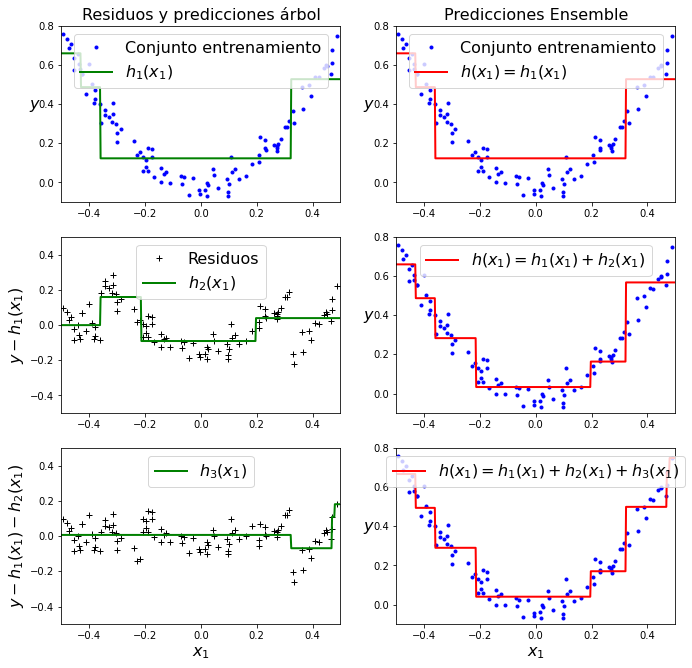

In [93]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], Xrand, yrand, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Conjunto entrenamiento")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuos y predicciones árbol", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], Xrand, yrand, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Conjunto entrenamiento")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Predicciones Ensemble", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], Xrand, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuos")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], Xrand, yrand, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], Xrand, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], Xrand, yrand, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Scikit-Learn tiene implementado la clase GradientBoostingRegressor para entrenar ensembles de GBRT. Al igual que la clase RandomForestRegressor, tiene hiperparámetros para
controlar el crecimiento de los Árboles de Decisión (por ejemplo, max_depth),
así como hiperparámetros para controlar el entrenamiento del conjunto, como el número de
árboles (n_estimators). El ejemplo anterior estaba formado por 3 árboles de decisión de profundidad 2 con una tasa de aprendizaje de 1. Es decir:

In [94]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)

X_train1, X_test1, y_train1, y_test1 = train_test_split(Xrand, yrand, random_state=49)
gbrt.fit(X_train1, y_train1)

y_pred_rand = gbrt.predict(X_test1)
print("RMSE sobre el conjunto de test:", np.sqrt(mean_squared_error(y_test1, y_pred_rand)))

RMSE sobre el conjunto de test: 0.08326959433325538


Probamos a añadir más estimadores al ensemble y reducimos el ratio de aprendizaje.

In [95]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1, random_state=42)

X_train1, X_test1, y_train1, y_test1 = train_test_split(Xrand, yrand, random_state=49)
gbrt_slow.fit(X_train1, y_train1)

y_pred_rand = gbrt_slow.predict(X_test1)
print("RMSE sobre el conjunto de test:", np.sqrt(mean_squared_error(y_test1, y_pred_rand)))

RMSE sobre el conjunto de test: 0.05359870742181778


El hiperparámetro learning_rate escala la contribución de cada árbol. Si ponemos un valor alto como 1, el método aprenderá más rápido, pero tenderá a sobreajustar. Si lo fijas a un valor algo más bajo, como 0.1, se necesitarán más árboles en el ensemble para ajustar el conjunto de entrenamiento, pero las predicciones habitualmente generalizarán mejor. 

Los siguiente figura contiene dos ensembles GBRT entrenados con un ratio de aprendizaje 1: el de la derecha no tiene suficientes árboles para ajustarse al conjunto de entrenamiento, mientras que el de la derecha tiene demasiados, realizando sobreajuste.

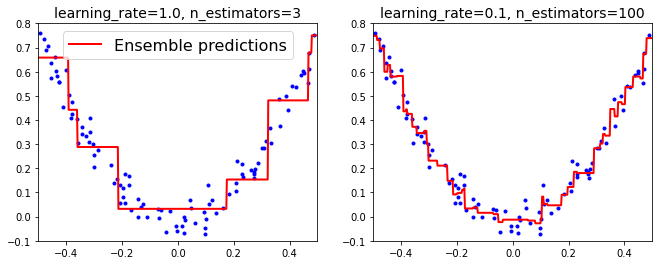

In [96]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], Xrand, yrand, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], Xrand, yrand, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

## Gradient Boosting con Parada Temprana

Para encontrar el número óptimo de árboles, puedes usar la parada temprana (early stopping). Una forma sencilla de implementarlo es utilizar el método staged_predict(): devuelve un iterador sobre las predicciones hechas por el conjunto en cada etapa del entrenamiento
(con un árbol, dos árboles, etc.). 

El siguiente código entrena un conjunto de GBRT con
120 árboles, luego mide el error de validación en cada etapa del entrenamiento para encontrar el óptimo
número de árboles, y finalmente entrena otro conjunto de GBRT usando el óptimo
número de árboles:

In [97]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train1, X_test1, y_train1, y_test1 = train_test_split(Xrand, yrand, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train1, y_train1)

errors = [mean_squared_error(y_test1, y_pred1) for y_pred1 in gbrt.staged_predict(X_test1)] # iterador sobre las predicciones hechas por el conjunto en cada etapa del entrenamiento
bst_n_estimators = np.argmin(errors) + 1
min_error = np.min(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train1, y_train1)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

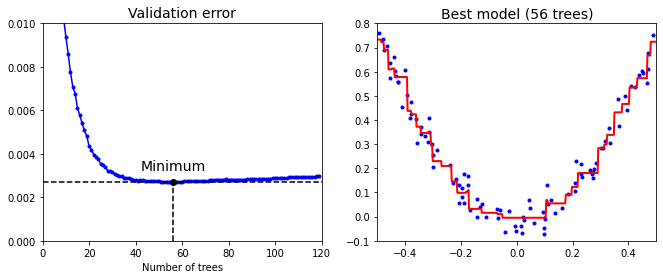

In [98]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], Xrand, yrand, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

#save_fig("early_stopping_gbrt_plot")
plt.show()

También es posible poner en práctica la detención temprana, deteniendo realmente el entrenamiento temprano
(en lugar de entrenar un gran número de árboles primero y luego mirar atrás para encontrar el
número óptimo). 

El siguiente código detiene el entrenamiento cuando el error de validación no
mejorar durante cinco iteraciones seguidas:

In [99]:
gbrt = GradientBoostingRegressor(max_depth=2, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train1, y_train1)
    y_pred1 = gbrt.predict(X_test1)
    val_error = mean_squared_error(y_test1, y_pred1)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [100]:
print(gbrt.n_estimators)

61


In [101]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


La clase GradientBoostingRegressor también tiene un hiperparámetro subsample que especifica la fracción de las instancias de entrenamiento a ser usadas por cada árbol en la fase de entrenamiento. Por ejemplo, subsample=0.25 especifica que cada árbol se entrena en el 25% de las instacias de entrenamiento seleccionadas aleatoriamente. Esto producirá menor ajuste pero el ensemble será mejor al tratarse de árboles más diferentes. También hará la fase de entrenamiento más rápida. Esta técnica se llama Stochastic Gradient Boosting.


Si lo utilizamos para clasificación con la base de datos Moons, con 500 árboles y un ratio de aprendizaje de 0.01. 

0.904
CPU times: user 373 ms, sys: 280 µs, total: 373 ms
Wall time: 374 ms


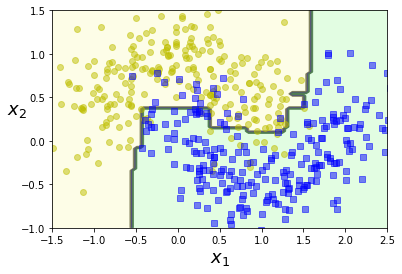

In [102]:
%%time
#from sklearn.model_selection import train_test_split
#from sklearn.datasets import make_moons

from sklearn.ensemble import GradientBoostingClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

#Generamos el conjunto de test y de entrenamiento que usaremos en esta práctica
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

gbrt_Class = GradientBoostingClassifier(max_depth=2, n_estimators=500, learning_rate=0.01, random_state=42)
gbrt_Class.fit(X_train, y_train)


y_pred = gbrt_Class.predict(X_test)
print(accuracy_score(y_test, y_pred))
plot_decision_boundary(gbrt_Class, X, y)


Tratando de encontrar el que produce menor error.

0.912
260


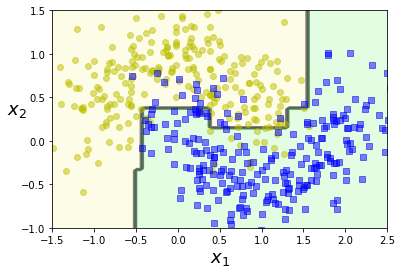

In [103]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt_Class.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_Class_best = GradientBoostingClassifier(max_depth=2,n_estimators=bst_n_estimators, learning_rate=0.01, random_state=42)
gbrt_Class_best.fit(X_train, y_train)
y_pred = gbrt_Class_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(bst_n_estimators)
plot_decision_boundary(gbrt_Class_best, X, y)

Nos dice que el óptimo lo alcanza con 260 árboles.

Con parada temprana

In [104]:
gbrt_Class = GradientBoostingClassifier(max_depth=2, learning_rate=0.01, random_state=42)

max_accuracy = 0
error_going_up = 0
for n_estimators in range(1, 500):
    gbrt_Class.n_estimators = n_estimators
    gbrt_Class.fit(X_train, y_train)
    y_pred = gbrt_Class.predict(X_test)
    accur = accuracy_score(y_test, y_pred)
    if max_accuracy < accur:
        max_accuracy = accur
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 10:
            break  # early stopping

print(gbrt_Class.n_estimators)
print(max_accuracy)

12
0.896


Ha parado con 12 árboles. Quizá demasiado pronto.

## Ejercicios Gradient boosting

EJERCICIO: Sobre la BD Diabetes realiza Gradient boosting. Utiliza 1000 estimadores y ratios de aprendizaje: 0.1, 0.25, 0.5 y 1. ¿Qué RMSE obtienes sobre el conjunto de entrenamiento en los cuatro métodos? ¿Y sobre el conjunto de test?¿Mejora los resultados con respecto al AdaBoosting?

In [105]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

# Solución


CPU times: user 14 µs, sys: 1e+03 ns, total: 15 µs
Wall time: 19.3 µs


EJERCICIO (Opcional): Incorpora al método anterior parada temprana. Explica la influencia que tiene para cada ratio de aprendizaje en la reducción de pasos de entrenamiento y en el RMSE del modelo.

In [106]:
# Solución


## XGBoost

Una implementación optimizada de Extreme Gradient Boosting está disponible en la popular biblioteca de python XGBoost. Este paquete fue desarrollado por Tianqi Chen y Carlos Guestrin ([publicado](https://arxiv.org/abs/1603.02754) en 2016), y su objetivo es ser extremadamente rápido, escalable y portátil. De hecho, XGBoost es a menudo un componente importante de las entradas ganadoras en las competiciones de ML. La API de XGBoost es bastante similar a la de Scikit-Learn:


In [107]:
import xgboost

Probamos de nuevo sobre el conjunto de entrenamiento aleatorio cuadrático.

In [108]:
np.random.seed(42)
Xrand = np.random.rand(100, 1) - 0.5
yrand = 3*Xrand[:, 0]**2 + 0.05 * np.random.randn(100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(Xrand, yrand, random_state=49)

xgb_reg = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1,  random_state=42)
xgb_reg.fit(X_train1, y_train1)
    
y_pred = xgb_reg.predict(X_test1)
val_error = mean_squared_error(y_test1, y_pred)
print("Validation MSE:", val_error)

[18:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


Recuperamos de nuevo el conjunto moons

0.912
CPU times: user 199 ms, sys: 7.28 ms, total: 206 ms
Wall time: 208 ms


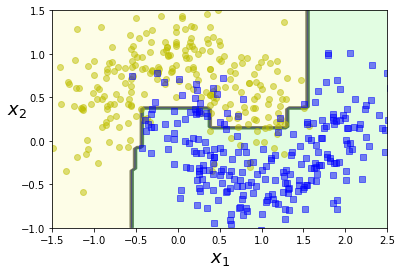

In [109]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

#Generamos el conjunto de test y de entrenamiento que usaremos en esta práctica
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_class = xgboost.XGBClassifier(max_depth=2, n_estimators=500, learning_rate=0.01, random_state=42)
xgb_class.fit(X_train, y_train)

y_pred = xgb_class.predict(X_test)
print(accuracy_score(y_test, y_pred))
plot_decision_boundary(xgb_class, X, y)


Se puede observar que es casi el doble de rápido que el método anterior.

## Ejercicio XGBoost

EJERCICIO: Sobre la BD Diabetes realiza Extreme Gradient boosting. Utiliza 1000 estimadores y ratio de aprendizaje: 0.1, 0.25, 0.5 y 1. ¿Qué RMSE obtienes sobre el conjunto de entrenamiento en los cuatro métodos? ¿Y sobre el conjunto de test?¿Mejora los resultados con respecto al Gradient boosting? ¿Se reduce el tiempo de ejecución?

In [110]:
# Solución


# Stacking

Vamos a utilizar los clasificadores individuales que definíamos (un árbol de decisión, una regresión logística y un SVM) al comienzo de la práctica para crear un primer nivel de clasificadores. 

Los resultados de estos clasificadores servirán como conjunto de entrenamiento a otro clasificador en un segundo nivel para hacer predicciones (blender). 

0.928


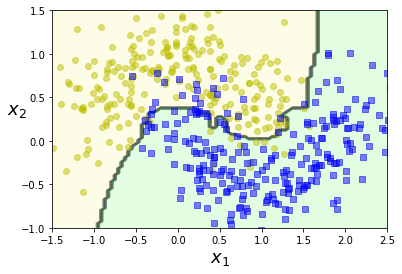

In [111]:
from sklearn.ensemble import StackingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# get a stacking ensemble of models

level0 = list()
level0.append(('log_clf', LogisticRegression(solver="liblinear", random_state=42)))
level0.append(('svm_clf', SVC(gamma="auto", probability=True, random_state=42)))
level0.append(('dt_clf', DecisionTreeClassifier(random_state=42)))
level0.append(('nb_clf', GaussianNB()))

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model_stack = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

model_stack.fit(X_train, y_train)

y_pred = model_stack.predict(X_test)
print(accuracy_score(y_test, y_pred))
plot_decision_boundary(model_stack, X, y)

El blender entrenado y los clasificadores previos forman el stacking ensemble.

## Ejercicios Stacking

EJERCICIO. Define stacking para la base de datos Diabetes. 
Puedes usar los modelos que definiamos al comienzo
de la práctica (regresión lineal, árbol de deción y SVM) para crear un primer nivel de clasificadores. Para el segundo nivel utiliza una regresión lineal. ¿Qué RMSE obtienes sobre el conjunto de entrenamiento? ¿Y sobre el conjunto de test? ¿Mejora los resultados?

In [112]:
# Solución

EJERCICIO (Opcional): Pruba a elegir otros hiperparámetros para este blender o elegir otro tipo de modelos en primer nivel o de blenders (por ejemplo, un `MLPRegressor`). ¿Qué RMSE obtienes sobre el conjunto de entrenamiento? ¿Y sobre el conjunto de test?¿Mejora los resultados?

In [113]:
# Solución